# 11.4. 随机梯度下降（stochastic gradient descent）
## 11.4.1. 随机梯度更新
在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值。给定$n$个样本的训练数据集，我们**假设$f_i(\mathbf{x})$是关于索引$i$的训练样本的损失函数 ，其中$\mathbf{x}$是参数向量**。然后我们得到**目标函数**

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).\tag{11.4.1}$$

$\mathbf{x}$的目标函数的梯度计算为

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).\tag{11.4.2}$$

如果使用梯度下降法，则每个自变量迭代的计算代价为$\mathcal{O}(n)$，它随$n$线性增长。因此，当训练数据集较大时，每次迭代的梯度下降计算代价将较高。随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们**对数据样本随机均匀采样一个索引$i$**，其中$i\in\{1,\ldots, n\}$，并计算梯度$\nabla f_i(\mathbf{x})$以更新$\mathbf{x}$：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),\tag{11.4.3}$$

其中$\eta$是学习率。我们可以看到，每次迭代的计算代价从梯度下降的$\mathcal{O}(n)$降至常数$\mathcal{O}(1)$。此外，我们要强调，**随机梯度$\nabla f_i(\mathbf{x})$是对完整梯度$\nabla f(\mathbf{x})$的无偏估计**，因为

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).\tag{11.4.4}$$

这意味着，平均而言，随机梯度是对梯度的良好估计。现在，我们将把它与梯度下降进行比较，方法是向梯度添加均值为0、方差为1的随机噪声，以模拟随机梯度下降。

epoch 50, x1: 0.276025, x2: 0.072547


/home/zhang/anaconda3/envs/d2l/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/home/zhang/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


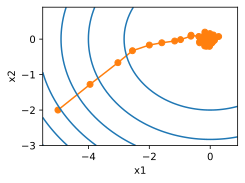

In [1]:
%matplotlib inline

import torch
import math
from d2l import torch as d2l

def f(x1,x2):  # 目标函数
    return x1**2+2*x2**2

def f_grad(x1,x2):  # 目标函数的梯度
    return 2*x1,4*x2

def sgd(x1,x2,s1,s2,f_grad):
    g1,g2=f_grad(x1,x2)
    #
    g1 += torch.normal(0.0,1,(1,))
    g2 += torch.normal(0.0,1,(1,))
    eta_t=eta * lr()
    return (x1-eta_t*g1,x2-eta_t*g2,0,0)

def constant_lr():
    return 1

eta=0.1
lr=constant_lr  # 常数学习速度
d2l.show_trace_2d(f,d2l.train_2d(sgd,steps=50,f_grad=f_grad))

正如我们所看到的，随机梯度下降中变量的轨迹比我们在11.3节中观察到的梯度下降中观察到的轨迹嘈杂得多。这是由于梯度的随机性质。也就是说，即使我们接近最小值，我们仍然受到通过$\eta \nabla f_i(\mathbf{x})$的瞬间梯度所注入的不确定性的影响。即使经过50次迭代，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会得到改善（我们鼓励你尝试更多的步骤来确认这一点）。这给我们留下了唯一的选择：**改变学习率$\eta$**。但是，如果我们选择的学习率太小，我们一开始就不会取得任何有意义的进展。另一方面，如果我们选择的学习率太大，我们将无法获得一个好的解决方案，如上所示。解决这些相互冲突的目标的唯一方法是在优化过程中**动态**降低学习率。

这也是在`sgd`步长函数中添加学习率函数`lr`的原因。在上面的示例中，学习率调度的任何功能都处于休眠状态，因为我们将相关的`lr`函数设置为常量。

## 11.4.2. 动态学习率
用与时间相关的学习率$\eta(t)$取代$\eta$增加了控制优化算法收敛的复杂性。特别是，我们需要弄清$\eta$的衰减速度。如果太快，我们将过早停止优化。如果减少的太慢，我们会在优化上浪费太多时间。以下是随着时间推移调整$\eta$时使用的一些基本策略（稍后我们将讨论更高级的策略）：

![avatar](../img/11_7.png)

在第一个**分段常数**（piecewise constant）场景中，我们会降低学习率，例如，每当优化进度停顿时。这是训练深度网络的常见策略。或者，我们可以通过**指数衰减**（exponential decay）来更积极地减低它。不幸的是，这往往会导致算法收敛之前过早停止。一个受欢迎的选择是$\alpha = 0.5$的**多项式衰减**（polynomial decay）。在凸优化的情况下，有许多证据表明这种速率表现良好。

让我们看看指数衰减在实践中是什么样子。

epoch 10000, x1: -0.838523, x2: -0.058889


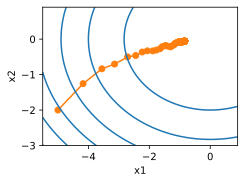

In [13]:
def exponential_lr():
    #
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f,d2l.train_2d(sgd,steps=10000,f_grad=f_grad))

正如预期的那样，参数的方差大大减少。但是，这是以未能收敛到最优解$\mathbf{x} = (0, 0)$为代价的。即使经过10000个迭代步骤，我们仍然离最优解很远。事实上，**该算法根本无法收敛**。另一方面，如果我们使用**多项式衰减**，其中学习率随迭代次数的平方根倒数衰减，那么仅在50次迭代之后，收敛就会更好。

epoch 50, x1: 0.201168, x2: 0.163080


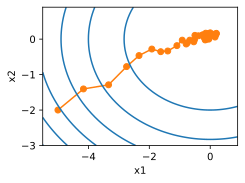

In [14]:
def polynomial_lr():
    #
    global t
    t += 1
    return (1+0.1*t) ** (-0.5)

t=1
lr=polynomial_lr
d2l.show_trace_2d(f,d2l.train_2d(sgd,steps=50,f_grad=f_grad))

关于如何设置学习率，还有更多的选择。例如，我们可以从较小的学习率开始，然后使其迅速上涨，再让它降低，尽管这会更慢。我们甚至可以在较小和较大的学习率之间切换。这样的计划各种各样。现在，让我们专注于可以进行全面理论分析的学习率计划，即**凸环境下的学习率**。对于一般的非凸问题，很难获得有意义的收敛保证，因为总的来说，最大限度地减少非线性非凸问题是NP困难的。有关的研究调查，请参阅例如2015年Tibshirani的优秀[讲义笔记](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf)。

## 11.4.3. 凸目标的收敛性分析
以下对凸目标函数的随机梯度下降的收敛性分析是可选的，主要用于传达对问题的更多直觉。我们只限于最简单的证明之一`Nesterov.Vial.2000`。存在着明显更先进的证明技术，例如，当目标函数表现特别好时。

假设所有$\boldsymbol{\xi}$的目标函数$f(\boldsymbol{\xi}, \mathbf{x})$在$\mathbf{x}$中都是凸的。更具体地说，我们考虑随机梯度下降更新：

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),\tag{11.4.6}$$

其中$f(\boldsymbol{\xi}_t, \mathbf{x})$是训练样本$f(\boldsymbol{\xi}_t, \mathbf{x})$的目标函数：$\boldsymbol{\xi}_t$从第$t$步的某个分布中提取，$\mathbf{x}$是模型参数。用

$$R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})] \tag{11.4.7}$$

表示期望风险，$R^*$表示对于$\mathbf{x}$的最低风险。最后让$\mathbf{x}^*$表示最小值（我们假设它存在于定义$\mathbf{x}$的域中）。在这种情况下，我们可以跟踪时间$t$处的当前参数$\mathbf{x}_t$和风险最小化器$\mathbf{x}^*$之间的距离，看看它是否随着时间的推移而改善：

![avatar](../img/11_8.png)

我们假设随机梯度$\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})$的$L_2$范数受到某个常数$L$的限制，因此我们有

$$\eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 \leq \eta_t^2 L^2.\tag{11.4.9}$$

我们最感兴趣的是$\mathbf{x}_t$和$\mathbf{x}^*$之间的距离如何变化的*期望*。事实上，对于任何具体的步骤序列，距离可能会增加，这取决于我们遇到的$\boldsymbol{\xi}_t$。因此我们需要点积的边界。因为对于任何凸函数$f$，所有$\mathbf{x}$和$\mathbf{y}$都满足$f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f'(\mathbf{x}), \mathbf{y} - \mathbf{x} \rangle$，按凸性我们有

$$f(\boldsymbol{\xi}_t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle.\tag{11.4.10}$$

将不等式11.4.9和11.4.10代入11.4.8我们在时间$t+1$时获得参数之间距离的边界，如下所示：

$$\|\mathbf{x}_{t} - \mathbf{x}^*\|^2 - \|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \geq 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^*)) - \eta_t^2 L^2.\tag{11.4.11}$$

这意味着，只要当前损失和最优损失之间的差异超过$\eta_t L^2/2$，我们就会取得进展。由于这种差异必然会收敛到零，因此学习率$\eta_t$也需要**消失**。接下来，我们根据公式11.4.11取期望。得到

$$E\left[\|\mathbf{x}_{t} - \mathbf{x}^*\|^2\right] - E\left[\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^*] -  \eta_t^2 L^2.\tag{11.4.12}$$

最后一步是对$t \in \{1, \ldots, T\}$的不等式求和。在求和过程中抵消中间项，然后舍去低阶项，可以得到

$$\|\mathbf{x}_1 - \mathbf{x}^*\|^2 \geq 2 \left (\sum_{t=1}^T   \eta_t \right) [E[R(\mathbf{x}_t)] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.\tag{11.4.13}$$

请注意，我们利用了给定的$\mathbf{x}_1$，因而可以去掉期望。最后定义

$$\bar{\mathbf{x}} \stackrel{\mathrm{def}}{=} \frac{\sum_{t=1}^T \eta_t \mathbf{x}_t}{\sum_{t=1}^T \eta_t}.\tag{11.4.14}$$

因为有

$$E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x}_t)}{\sum_{t=1}^T \eta_t}\right) = \frac{\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)]}{\sum_{t=1}^T \eta_t} = E[R(\mathbf{x}_t)],\tag{11.4.15}$$

根据詹森不等式（令公式11.2.3中$i=t$，$\alpha_i = \eta_t/\sum_{t=1}^T \eta_t$）和$R$的凸性使其满足的$E[R(\mathbf{x}_t)] \geq E[R(\bar{\mathbf{x}})]$，因此，

$$\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)] \geq \sum_{t=1}^T \eta_t  E\left[R(\bar{\mathbf{x}})\right].\tag{11.4.16}$$

将其代入不等式11.4.13得到边界

$$
\left[E[\bar{\mathbf{x}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t},\tag{11.4.17}
$$

其中$r^2 \stackrel{\mathrm{def}}{=} \|\mathbf{x}_1 - \mathbf{x}^*\|^2$是初始选择参数与最终结果之间距离的边界。简而言之，收敛速度取决于随机梯度标准的限制方式（$L$）以及初始参数值与最优结果的距离（$r$）。请注意，边界由$\bar{\mathbf{x}}$而不是$\mathbf{x}_T$表示。因为$\bar{\mathbf{x}}$是优化路径的平滑版本。只要知道$r, L$和$T$，我们就可以选择学习率$\eta = r/(L \sqrt{T})$。这个就是上界$rL/\sqrt{T}$。也就是说，我们将按照速度$\mathcal{O}(1/\sqrt{T})$收敛到最优解。


## 11.4.4. 随机梯度和有限样本
到目前为止，在谈论随机梯度下降时，我们进行得有点快而松散。我们假设从分布$p(x, y)$中采样得到样本$x_i$（通常带有标签$y_i$），并且用它来以某种方式更新模型参数。特别是，对于有限的样本数量，我们仅仅讨论了由某些允许我们在其上执行随机梯度下降的函数$\delta_{x_i}$和$\delta_{y_i}$组成的离散分布$p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$。

但是，这不是我们真正做的。在本节的简单示例中，我们只是将噪声添加到其他非随机梯度上，也就是说，我们假装有成对的$(x_i, y_i)$。事实证明，这种做法在这里是合理的（有关详细讨论，请参阅练习）。更麻烦的是，在以前的所有讨论中，我们显然没有这样做。相反，我们遍历了所有实例**恰好一次**。要了解为什么这更可取，可以反向考虑一下，即我们**有替换地**从离散分布中采样$n$个观测值。随机选择一个元素$i$的概率是$1/n$。因此选择它**至少**一次就是

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63.\tag{11.4.18}$$

类似的推理表明，挑选一些样本（即训练示例）**恰好一次**的概率是

$${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37.\tag{11.4.19}$$

这导致与**无替换**采样相比，方差增加并且数据效率降低。因此，在实践中我们执行后者（这是本书中的默认选择）。最后一点注意，重复采用训练数据集的时候，会以**不同的**随机顺序遍历它。

## 11.4.5. 小结

* 对于凸问题，我们可以证明，对于广泛的学习率选择，随机梯度下降将收敛到最优解。
* 对于深度学习而言，情况通常并非如此。但是，对凸问题的分析使我们能够深入了解如何进行优化，即逐步降低学习率，尽管不是太快。
* 如果学习率太小或太大，就会出现问题。实际上，通常只有经过多次实验后才能找到合适的学习率。
* 当训练数据集中有更多样本时，计算梯度下降的每次迭代的代价更高，因此在这些情况下，首选随机梯度下降。
* 随机梯度下降的最优性保证在非凸情况下一般不可用，因为需要检查的局部最小值的数量可能是指数级的。